# Import Libraries

In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import seaborn as sn #for heatmaps
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

%matplotlib inline

In [2]:
transform = transforms.ToTensor()

In [19]:
train_data = datasets.CIFAR10(root='data/', train=True, download=True, transform=transform)

In [20]:
test_data = datasets.CIFAR10(root='data/', train=False, download=True, transform=transform)

Files already downloaded and verified


In [21]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [22]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: ToTensor()

In [33]:
torch.manual_seed(101)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [34]:
classe_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [35]:
for images, labels in train_loader:
    break

In [36]:
labels

tensor([1, 5, 8, 1, 6, 1, 6, 3, 7, 9])

Label:  [1 5 8 1 6 1 6 3 7 9]
Class:  car dog ship car frog car frog cat horse truck


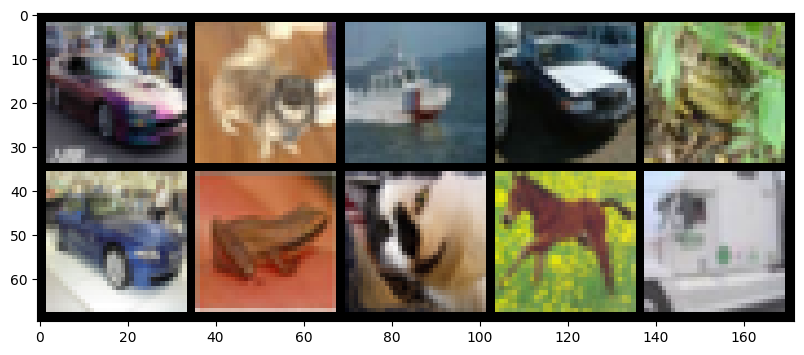

In [45]:
print("Label: ", labels.numpy())
print("Class: ", *np.array([classe_names[i] for i in labels]))
im = make_grid(images, nrow=5)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(),(1,2,0)));

# Model

In [49]:
class ConvulationalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(6*6*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 6*6*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        pred = F.log_softmax(X, dim=1)
        return pred        

## Calculation of `self.fc1 = nn.Linear(6*6*16, 120)` this part

In [46]:
images[0].shape

torch.Size([3, 32, 32])

In [47]:
(((32-2)//2)-2)//2

6

# Use model

In [50]:
torch.manual_seed(101)
model = ConvulationalNetwork()
model

ConvulationalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [51]:
for param in model.parameters():
    print(param.numel())

450
6
864
16
69120
120
10080
84
840
10


In [52]:
# Hyper Parameter
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [53]:
from time import time
start_time = time()

EPOCHS = 10

train_losses = []
test_losses = []

train_correct = []
test_correct = []


for epoch in range(1, EPOCHS+1):
    trn_corr = 0 
    tst_corr = 0 
    
    # Train 
    for b, (X_train, y_train) in enumerate(train_loader, 1):
        y_pred = model(X_train) # Not Flatten!
        loss = criterion(y_pred, y_train)
        
        pred = torch.max(y_pred.data, 1)[1]
        batch_corr = (pred == y_train).sum()
        trn_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%600==0:
            print(f"EPOCH: {epoch} BATCH: {b} LOSS: {loss.item()}")
        
    train_losses.append(loss.item())
    train_correct.append(trn_corr)
    
    # TEST
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader, 1):
            y_pred = model(X_test) # Not Flatten!
            loss = criterion(y_pred, y_test)

            pred = torch.max(y_pred.data, 1)[1]
            batch_corr = (pred == y_test).sum()
            tst_corr += batch_corr

    test_losses.append(loss.item())
    test_correct.append(tst_corr)

current_time = time()
print(f"Execution Time: {(current_time-start_time)/60:.2f} minutes")

EPOCH: 1 BATCH: 600 LOSS: 1.9037106037139893
EPOCH: 1 BATCH: 1200 LOSS: 1.5825892686843872
EPOCH: 1 BATCH: 1800 LOSS: 0.9763080477714539
EPOCH: 1 BATCH: 2400 LOSS: 1.5633738040924072
EPOCH: 1 BATCH: 3000 LOSS: 0.9558178782463074
EPOCH: 1 BATCH: 3600 LOSS: 2.026777505874634
EPOCH: 1 BATCH: 4200 LOSS: 1.2092130184173584
EPOCH: 1 BATCH: 4800 LOSS: 1.1762511730194092
EPOCH: 2 BATCH: 600 LOSS: 2.315526008605957
EPOCH: 2 BATCH: 1200 LOSS: 1.578378438949585
EPOCH: 2 BATCH: 1800 LOSS: 1.5432822704315186
EPOCH: 2 BATCH: 2400 LOSS: 1.1024208068847656
EPOCH: 2 BATCH: 3000 LOSS: 1.3484176397323608
EPOCH: 2 BATCH: 3600 LOSS: 2.1404483318328857
EPOCH: 2 BATCH: 4200 LOSS: 1.3880388736724854
EPOCH: 2 BATCH: 4800 LOSS: 0.7490202784538269
EPOCH: 3 BATCH: 600 LOSS: 1.1851707696914673
EPOCH: 3 BATCH: 1200 LOSS: 1.7968389987945557
EPOCH: 3 BATCH: 1800 LOSS: 0.9920673370361328
EPOCH: 3 BATCH: 2400 LOSS: 0.9774712324142456
EPOCH: 3 BATCH: 3000 LOSS: 1.4424530267715454
EPOCH: 3 BATCH: 3600 LOSS: 1.25319063663

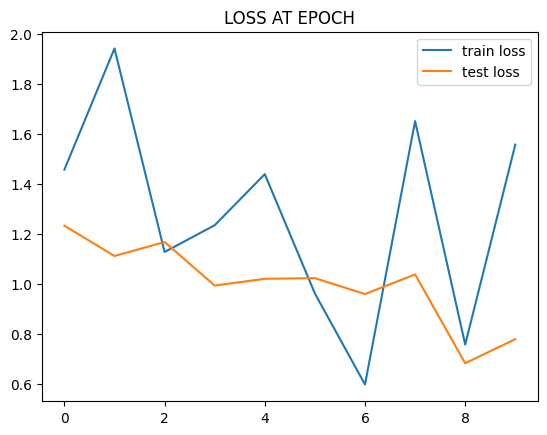

In [54]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.title("LOSS AT EPOCH")
plt.legend();

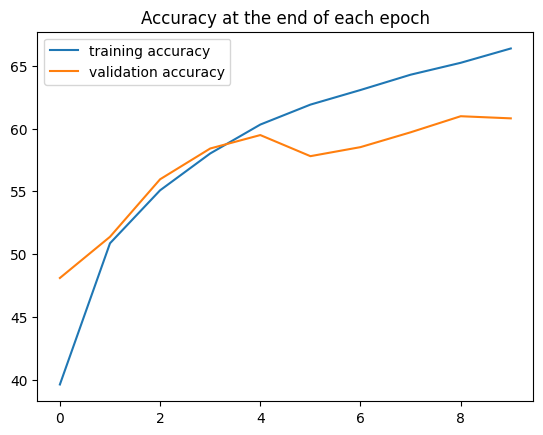

In [56]:
plt.plot([t/500 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title("Accuracy at the end of each epoch")
plt.legend();

In [57]:
test_loader_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [58]:
# TEST
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_loader_all:
        y_pred = model(X_test) # Not Flatten!

        pred = torch.max(y_pred.data, 1)[1]
        correct += (pred==y_test).sum()

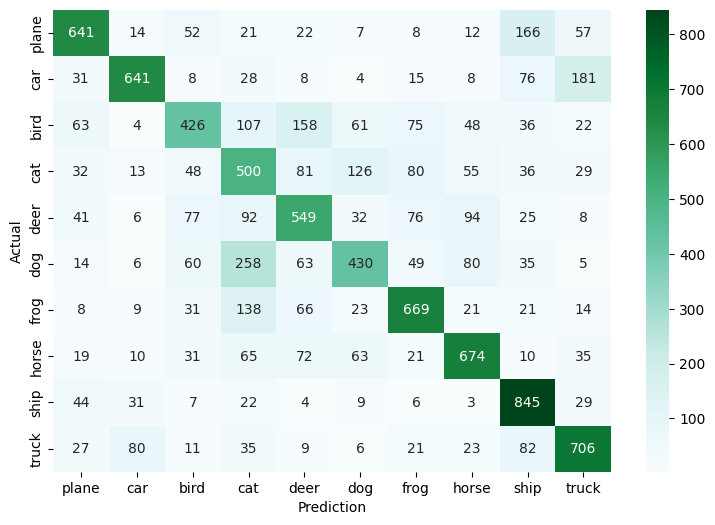

In [62]:
arr = confusion_matrix(y_test.view(-1), pred.view(-1))
df_cm = pd.DataFrame(arr, classe_names, classe_names)
plt.figure(figsize=(9,6))
sn.heatmap(df_cm, annot=True, fmt='d', cmap="BuGn")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show();